# Create crystal structure for ML from stable structure 

1. obtain stable structure from materials project
2. create supercell
3. randomly displace atoms while compressing or expanding the cell

In [212]:
# load ASE atom from POSCAR file
from ase.io.vasp import read_vasp
import matplotlib.pyplot as plt

In [213]:
import numpy as np

from ase import Atoms
from ase.neighborlist import NeighborList
from ase.build import make_supercell

from ovito.modifiers import CoordinationAnalysisModifier
from ovito.pipeline import StaticSource, Pipeline
from ovito.io.ase import ase_to_ovito

def get_rdf(ase_atoms, rcut=6, bins=100) -> np.ndarray:
    """get radial distribution function val

    Args:
        rcut (int, optional): cutoff radius. Defaults to 6.
        bins (int, optional): _description_. Defaults to 100.

    Returns:
        np.ndarray: 1st: distance, 2nd: rdf value
    """
    pipeline = Pipeline(source = StaticSource(data=ase_to_ovito(ase_atoms)))
    # modifier = CoordinationAnalysisModifier(cutoff=rcut, number_of_bins=bins, partial=True)
    modifier = CoordinationAnalysisModifier(cutoff=rcut, number_of_bins=bins)
    pipeline.modifiers.append(modifier)
    rdf_table = pipeline.compute().tables['coordination-rdf']
    return rdf_table

In [214]:
# randomly displace atoms while compressing or expanding the cell
from ase.build import make_supercell

path2POSCAR = '/Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/mp-546794/original/POSCAR'

original_atoms = read_vasp(path2POSCAR)
original_atoms = make_supercell(original_atoms, [[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [215]:
# save ase atom with pkl
import pickle

with open('/Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/mp-546794/original/original_atoms.pkl', 'wb') as f:
    pickle.dump(original_atoms, f)

In [216]:
# load ase atom with pkl
import pickle

with open('/Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/mp-546794/original/original_atoms.pkl', 'rb') as f:
    original_atoms = pickle.load(f)

In [217]:
def get_near_crystal(atoms, displacement, scale):
    atoms = atoms.copy()
    # add displacement
    atoms.rattle(stdev=displacement)
    # scale cell
    atoms.set_cell(atoms.get_cell() * scale, scale_atoms=True)
    return atoms

In [218]:
displacement_list = np.linspace(0.03, 0.1, 20)
scale_list = np.linspace(0.7, 1.3, 20)
num_samples = 1000

all_atoms = []
for i in range(num_samples):
    displacement = np.random.choice(displacement_list)
    scale = np.random.choice(scale_list)
    atoms = get_near_crystal(original_atoms, displacement, scale)
    all_atoms.append(atoms)

In [219]:
rdf_list = []
distance = get_rdf(all_atoms[0], bins=150).xy()[:, 0]
for atoms in all_atoms:
    rdf_list.append(get_rdf(atoms, bins=150).xy()[:, 1])

rdf_list = np.array(rdf_list)

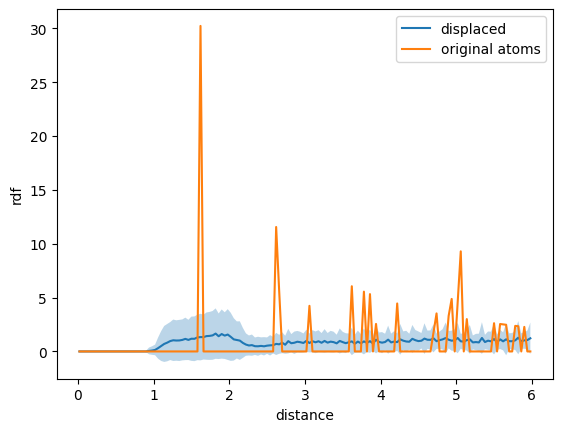

In [220]:
# plot rdf
fig, ax = plt.subplots()
ax.plot(distance, rdf_list.mean(axis=0), label='displaced')
ax.fill_between(distance, rdf_list.mean(axis=0) - rdf_list.std(axis=0), rdf_list.mean(axis=0) + rdf_list.std(axis=0), alpha=0.3)

# plot original atoms rdf
original_atoms_rdf = get_rdf(original_atoms, bins=150).xy()
ax.plot(original_atoms_rdf[:, 0], original_atoms_rdf[:, 1], label='original atoms')
ax.legend()
ax.set_xlabel('distance')
ax.set_ylabel('rdf')
plt.show()

In [206]:
def get_param_idx(param, lines):
    for i, line in enumerate(lines):
        if param in line:
            return i
    return None

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

In [207]:
path_scf_input_template = "/Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/mp-546794/template"
path_root_result = "/home/y1u0d2/result/qe/SiO2/mp-546794/result"

with open(f'{path_scf_input_template}/scf.in') as f:
    original_scf_input_lines = [s.strip() for s in f.readlines()]

for i, atoms in enumerate(all_atoms):
    scf_input_lines = original_scf_input_lines.copy()

    num_atoms = atoms.get_global_number_of_atoms()
    # change num of atoms
    num_atoms_idx = get_param_idx('nat', scf_input_lines)
    scf_input_lines[num_atoms_idx] = f'nat = {num_atoms}'

    cell_lines = []
    for vec in atoms.get_cell():
        cell_line = ' '.join(map(str, vec))
        cell_lines.append(cell_line)
        print(cell_line)
    # change cell
    cell_idx = get_param_idx('CELL_PARAMETERS {angstrom}', scf_input_lines) 
    # insert list to list
    scf_input_lines.insert(cell_idx+1, cell_lines[0])
    scf_input_lines.insert(cell_idx+2, cell_lines[1])
    scf_input_lines.insert(cell_idx+3, cell_lines[2])

    position_lines = []
    for symbol, scaled_position in zip(atoms.get_chemical_symbols(), atoms.get_scaled_positions()):
        position_line = f'{symbol} ' + ' '.join(map(str, scaled_position))
        position_lines.append(position_line)
        print(position_line)
    # change position
    position_idx = get_param_idx('ATOMIC_POSITIONS {crystal}', scf_input_lines)
    scf_input_lines.insert(position_idx+1, position_lines)

    scf_input_lines = flatten(scf_input_lines)

    # create dir
    path2result = f'{path_root_result}/scf_{i}'
    if not os.path.exists(path2result):
        os.makedirs(path2result)
    else:
        print(f'{path2result} already exists')

    # write scf.in
    with open(f'{path2result}/scf.in', 'w') as f:
        f.writelines('\n'.join(scf_input_lines))
    
    break

12
3.9375879985798927 0.0 0.0
0.0 3.9375879985798927 0.0
0.0 0.0 5.810593237540547
Si 0.008178576221896007 0.9977234288190896 0.00722681905192434
Si 0.5250772314284644 0.9961445809200736 0.7473875322447396
Si 0.5260023039487063 0.512636087354582 0.49476166978866987
Si 0.008933445210937497 0.4923696619066213 0.24480345187824482
O 0.6007701253599654 0.7184971563223653 0.6057536055963505
O 0.74074173468052 0.08010950327747528 0.8785063282374515
O 0.23504905876358448 0.8799597843255469 0.8913535060813833
O 0.399496382444164 0.2511118760474608 0.6091028569588162
O 0.0878226736953598 0.2518263801205836 0.11215737298926098
O 0.2561860022727919 0.5868963991003661 0.3717453215174768
O 0.7400926853774881 0.4337122929346468 0.3748493998347258
O 0.8857982811733967 0.7635434962317585 0.11137799554874979


In [ ]:
from glob import glob
import os
import subprocess
import random

n_parallel = 40
path2root = "/home/y1u0d2/result/qe/SiO2/mp-546794/result"
scf_dirs = glob(f'{path2root}/scf*')

# shuffle list
random.shuffle(scf_dirs)

for scf_dir in scf_dirs:
    if os.path.exists(f'{scf_dir}/scf.out'):
        print(f'{scf_dir}/scf.out already exists')
        continue
    
    process = subprocess.Popen(
    f'mpiexec.hydra -n {n_parallel} -machine $TMPDIR/machines pw.x -in {scf_dir}/scf.in > {scf_dir}/scf.out',
    shell=True)
    process.wait()